<a href="https://colab.research.google.com/github/imrashmi/Google-Colab-Codes/blob/python_scripts/email_automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


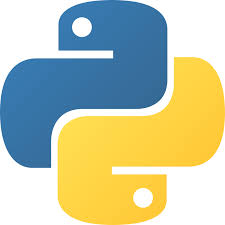 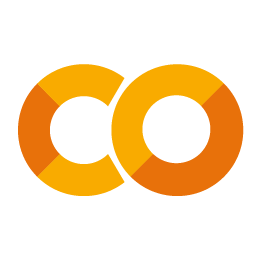

**This Email Automation Script is a powerful tool designed to automate the  process of sending emails to multiple recipients with minimal user intervention. It supports sending emails with personalized content, including file attachments, and logs the results of each sent email. The script is built for users who want to efficiently manage large-scale email campaigns or distribution tasks with minimal manual effort.**

---

### Usage Procedure for the Email Automation Script

---

#### 1. **Install the Required Packages:**
- Ensure you have installed the following packages:

    ```bash
    pip install python-docx pandas openpyxl markdown pypandoc pytz
    ```

- These are essential for handling email automation, file conversions, and logging.

---

#### 2. **Run the Script:**

- **Step 1:** Launch the script in your Python environment (e.g., Google Colab, Jupyter, or local Python setup).
  
- **Step 2:** You will be prompted to provide necessary details. Here's a step-by-step guide:

---

#### 3. **Input Details:**

- **Sender Gmail Address:**  
    Enter your Gmail address (it will automatically append "@gmail.com" if not included).

- **Sender Name:**  
    Provide your name, which will appear in the email as the sender.

- **Gmail App Password:**  
    Use your Gmail app-specific password (not your regular Gmail password). You can generate this in your Gmail account settings.

---

#### 4. **Email Reply-To Information:**

- **Reply-To Email Address (Optional):**  
    You can specify a different reply-to email address or leave it blank to use the sender email.

- **Reply-To Name (Optional):**  
    Provide a name that will appear as the reply-to name, or leave blank to use the sender name.

---

#### 5. **Select Email Subject and Files:**

- **Email Subject:**  
    Input the subject of the email you want to send.

- **Select Sender List File:**
    Browse and select a sender list file. This can be a `.csv`, `.txt`, or `.xlsx` file containing email addresses.

- **Select Email Body File:**  
    Browse and select an email body file. Supported formats are `.doc`, `.docx`, `.txt`, `.md`, `.html`, and `.rtf`.

- **Optional Attachment:**  
    You can select a file to attach to the email (any file type), or skip if no attachment is needed.

---

#### 6. **Log Files:**

- **Success and Failure Lists:**  
    After running, the script will generate logs indicating which emails were sent successfully and which ones failed.

- **Execution Log:**  
    All details about the execution will be stored in an `execution_log.txt` file, which will be zipped along with other logs and sent to your email.

---

#### 7. **Automated Log Email:**

- After the script finishes execution, it will zip all log files and send them to your Gmail address.

---

#### 8. **Script Output:**

- The script will display status messages such as "Email sent" or "Failed to send email," which will also be logged in the `execution_log.txt` file.

---

### Error Handling:

- If any errors occur during execution (e.g., missing files, invalid email addresses, SMTP failures), they will be logged with a traceback in the execution log.

---

### Example Use Case:

1. **Gmail:** yourname@gmail.com  
2. **Subject:** Monthly Report  
3. **Sender List:** list.csv  
4. **Body:** email_body.docx  
5. **Attachment:** report.pdf  


```
For better result (high success rate) with Gmail use sender list of 24 address
```
---

In [ ]:
!pip install python-docx
import os
import sys
import subprocess
import importlib
import traceback
import time
from datetime import datetime
import re
import smtplib
import pandas as pd
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
from tkinter import Tk
from tkinter.filedialog import askopenfilename
import getpass  # Hides password input
import markdown
from docx import Document
import zipfile
import pytz  # For timezone handling

# Function to check and install missing packages
def install_package(package, correct_name=None):
    try:
        importlib.import_module(package)
    except ImportError:
        print(f"Installing {correct_name or package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", correct_name or package])

# Install required libraries
required_libraries = {
    'smtplib': None,  # comes pre-installed
    'pandas': None,
    'tkinter': None,
    'docx': 'python-docx',
    'markdown': None,
    'openpyxl': None,
    'pypandoc': None
}

for lib, correct_name in required_libraries.items():
    install_package(lib, correct_name)

# Function to log execution details with timestamp
def log_execution(details, log_file="execution_log.txt"):
    timestamp = datetime.now(pytz.timezone('UTC')).strftime('%d:%m:%Y / %H:%M:%S.%f / UTC')
    with open(log_file, "a") as log:
        log.write(f"[{timestamp}] {details}\n")

# Helper function to convert docx paragraphs to HTML while preserving formatting
def docx_to_html(doc):
    html_content = ""
    for para in doc.paragraphs:
        html_content += f"<p>{process_run(para)}</p>"
    return html_content

# Process docx runs (which contains inline formatting like bold and italics)
def process_run(para):
    html_paragraph = ""
    for run in para.runs:
        text = run.text
        if run.bold:
            text = f"<strong>{text}</strong>"
        if run.italic:
            text = f"<em>{text}</em>"
        if run.underline:
            text = f"<u>{text}</u>"
        html_paragraph += text
    return html_paragraph

# Function to convert the input body into HTML format while preserving text formatting
def convert_to_html(file_path):
    _, file_extension = os.path.splitext(file_path)

    if file_extension in ['.doc', '.docx']:
        doc = Document(file_path)
        html_content = "<html><body>"
        html_content += docx_to_html(doc)
        html_content += "</body></html>"

    elif file_extension == '.txt':
        with open(file_path, 'r') as f:
            text = f.read()
        html_content = "<html><body><p>{}</p></body></html>".format(text.replace('\n', '<br>'))

    elif file_extension == '.md':
        with open(file_path, 'r') as f:
            text = f.read()
        html_content = markdown.markdown(text)

    elif file_extension == '.rtf':
        import pypandoc
        html_content = pypandoc.convert_file(file_path, 'html')

    elif file_extension == '.html':
        with open(file_path, 'r') as f:
            html_content = f.read()

    else:
        raise ValueError("Unsupported file format. Please use .doc, .docx, .txt, .md, .rtf, or .html.")

    return html_content

# Function to send email with optional attachment
def send_email_with_attachment(smtp_server, port, sender_email, sender_password, sender_name, recipient_email, subject, html_body, file_path=None, reply_to=None, reply_to_name=None):
    try:
        msg = MIMEMultipart()
        msg['From'] = f"{sender_name} <{sender_email}>"
        msg['To'] = recipient_email
        msg['Subject'] = subject

        if reply_to:
            msg.add_header('Reply-To', f"{reply_to_name} <{reply_to}>")

        msg.attach(MIMEText(html_body, 'html'))

        if file_path and os.path.isfile(file_path):
            filename = os.path.basename(file_path)
            attachment = open(file_path, "rb")
            part = MIMEBase('application', 'octet-stream')
            part.set_payload(attachment.read())
            encoders.encode_base64(part)
            part.add_header('Content-Disposition', f"attachment; filename= {filename}")
            msg.attach(part)

        with smtplib.SMTP(smtp_server, port) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, recipient_email, msg.as_string())
            print(f"Email sent to {recipient_email}")
            return f"Email sent to {recipient_email}"

    except Exception as e:
        print(f"Failed to send email to {recipient_email}: {e}")
        return f"Failed to send email to {recipient_email}: {e}"

# Function to send the execution log to the sender email
def send_execution_log(sender_email, smtp_server, port, sender_password, zip_filename):
    log_subject = f"Execution Log ({datetime.now().strftime('%Y-%m-%d %H:%M:%S')})"
    try:
        msg = MIMEMultipart()
        msg['From'] = sender_email
        msg['To'] = sender_email
        msg['Subject'] = log_subject
        msg.attach(MIMEText("Execution log and associated files.", 'plain'))

        with open(zip_filename, "rb") as zipf:
            part = MIMEBase('application', 'zip')
            part.set_payload(zipf.read())
            encoders.encode_base64(part)
            part.add_header('Content-Disposition', f"attachment; filename= {zip_filename}")
            msg.attach(part)

        with smtplib.SMTP(smtp_server, port) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, sender_email, msg.as_string())
            print("Execution log sent to source email.")
    except Exception as e:
        print(f"Failed to send execution log: {e}")

# Function to parse email list from CSV, TXT, or XLSX files
def parse_email_list(file_path):
    _, file_extension = os.path.splitext(file_path)

    if file_extension == '.csv':
        df = pd.read_csv(file_path)
    elif file_extension == '.txt':
        with open(file_path, 'r') as f:
            content = f.read()
        df = pd.DataFrame(re.findall(r'[\w\.-]+@[\w\.-]+', content), columns=['Email'])
    elif file_extension == '.xlsx':
        df = pd.read_excel(file_path)
    else:
        raise ValueError("Unsupported file format. Please use .csv, .txt, or .xlsx.")

    email_list = df['Email'].dropna().unique()
    return email_list

# Function to ask for file input from user (supports regular Python IDE and Jupyter/Colab)
def browse_file(file_types, prompt_message):
    print(prompt_message)

    try:
        from google.colab import files
        print("You are using Google Colab. Please upload the file.")
        uploaded = files.upload()
        file_path = list(uploaded.keys())[0]
        return file_path
    except ImportError:
        Tk().withdraw()
        file_path = askopenfilename(filetypes=file_types)
        return file_path

# Function to zip log files and attachments, including used files
def zip_log_files(success_list, failure_list, execution_log, attachment_file=None, sender_file=None, body_file=None, html_body=None):
    zip_filename = f"email_logs_{datetime.now().strftime('%Y%m%d_%H%M%S')}.zip"
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        with open('success_list.txt', 'w') as f:
            f.write("\n".join(success_list))
        zipf.write('success_list.txt')

        with open('failure_list.txt', 'w') as f:
            f.write("\n".join(failure_list))
        zipf.write('failure_list.txt')

        with open('execution_log.txt', 'w') as f:
            f.write(execution_log)
        zipf.write('execution_log.txt')

        if attachment_file:
            zipf.write(attachment_file)

        if sender_file:
            zipf.write(sender_file)

        if body_file:
            with open('body_file.html', 'w') as f:
                f.write(html_body)
            zipf.write('body_file.html')

    print(f"Logs and files have been zipped into {zip_filename}")
    return zip_filename

def ensure_gmail_format(email):
    if '@' not in email:
        email += '@gmail.com'
    elif '@gmail.com' not in email:
        email = email.split('@')[0] + '@gmail.com'
    return email

def main():
    execution_log = "Execution Log:\n"
    success_list = []
    failure_list = []

    try:
        sender_email = input("Enter your Gmail address: ")
        sender_email = ensure_gmail_format(sender_email)
        sender_name = input("Enter your name: ")
        sender_password = getpass.getpass("Enter your Gmail app password: ")

        reply_to_email = input("Enter the reply-to email address (or leave blank to use sender email): ")
        reply_to_email = reply_to_email if reply_to_email else sender_email
        reply_to_name = input("Enter the name for the reply-to address (or leave blank to use your name): ")
        reply_to_name = reply_to_name if reply_to_name else sender_name

        smtp_server = 'smtp.gmail.com'
        port = 587

        subject = input("Please Enter Email Subject: ")
        execution_log += f"Subject: {subject}\n"

        sender_file = browse_file([("CSV files", "*.csv"), ("Text files", "*.txt"), ("Excel files", "*.xlsx")],
                                  "Please select the sender list file (CSV, TXT, or XLSX):")
        recipient_emails = parse_email_list(sender_file)
        execution_log += f"Sender list: {sender_file}, Total Recipients: {len(recipient_emails)}\n"

        body_file = browse_file([("Word files", "*.docx *.doc"), ("Text files", "*.txt"),
                                 ("Markdown files", "*.md"), ("HTML files", "*.html"),
                                 ("Rich Text Format", "*.rtf")],
                                "Please select the email body file:")
        html_body = convert_to_html(body_file)
        execution_log += f"Body file: {body_file}\n"

        attachment_file = browse_file([("All files", "*.*"), ("PDF files", "*.pdf"), ("Word files", "*.docx *.doc")],
                                       "Please select an attachment file (or cancel if none):")
        execution_log += f"Attachment: {attachment_file or 'No attachment'}\n"

        for recipient_email in recipient_emails:
            result = send_email_with_attachment(smtp_server, port, sender_email, sender_password, sender_name, recipient_email, subject, html_body, attachment_file, reply_to_email, reply_to_name)
            if "Email sent" in result:
                success_list.append(recipient_email)
            else:
                failure_list.append(recipient_email)
            execution_log += result + "\n"

    except Exception as e:
        execution_log += "Error: " + str(e) + "\n"
        execution_log += traceback.format_exc() + "\n"

    zip_filename = zip_log_files(success_list, failure_list, execution_log, attachment_file, sender_file, body_file, html_body)

    send_execution_log(sender_email, smtp_server, port, sender_password, zip_filename)

if __name__ == "__main__":
    main()
